# This notebook is an attempt to get position from the sensor recordings taken during our motion capture tests

In [61]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import json

# helper function
from IPython.display import Markdown, display
def print_h1(value):
    display(Markdown("# " + str(value)))
    
def print_h2(value):
    display(Markdown("## " + str(value)))
        
def print_h3(value):
    display(Markdown("### " + str(value)))

def print_md(value):
    display(Markdown(value))
    
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['figure.facecolor'] = 'black'
mpl.rcParams['figure.titlesize'] = 24
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.facecolor'] = 'white'

## Read MoCap data and RoboRIO data form files

In [62]:
data_dir = "../../recorded_sensor_data/mocap_12_10-03-30-00/"
sensor_file = data_dir + "sensor_data.csv"
mocap_file = data_dir + "mocap_data.csv"
extra_points_file = data_dir + "extra_points.json"
sensor_reader = csv.reader(open(sensor_file, 'r'))
extra_points = json.load(open(extra_points_file, 'r'))
mocap_reader = csv.reader(open(mocap_file, 'r'))

# placeholder for missing pieces of data (tags were not captured very reliably)
MISSING_DATA = -123456789

# read offset to center of robot
template_centroid = np.array(extra_points['template_centroid'])
robot_center = np.array(extra_points['template_centroid'])
robot_center_offset = robot_center - template_centroid 

# skip headers
headers = next(sensor_reader)
for i in range(5):
    next(mocap_reader)

sensor_data = []
for sensor_row in sensor_reader:
    data = [float(d) for d in sensor_row]
    # FYI: negate encoder rates
    mask = np.ones(len(data))
    mask[10] = -1
    data = data * mask
    sensor_data.append(data)
# sensor data is a Nx15 array. N is the number of data points
sensor_data = np.array(sensor_data)
print("sensor_data shape:", sensor_data.shape)
print("idx header")
for i, h in enumerate(headers):
    print(i, h)

mocap_data = []
for mocap_row in mocap_reader:
    data = []
    for idx, d in enumerate(mocap_row):
        try:
            float_d = float(d)
            if idx == 4:
                if float_d < -np.pi:
                    float_d += 4 * np.pi
            data.append(float_d)
        except ValueError:
            data.append(MISSING_DATA)
    mocap_data.append(data)
mocap_data = np.array(mocap_data)

sensor_data shape: (1286, 15)
idx header
0 accel_x
1 accel_y
2 accel_z
3 gyro_x
4 gyro_y
5 gyro_z
6 x
7 y
8 z
9 left_encoder_rate
10 right_encoder_rate
11 left_input
12 right_input
13 fpga time
14 navx time


### Check the amount of data between the two matches?

In [63]:
# these should be pretty darn close
print("Seconds of IMU data recorded (by stamp): ", (sensor_data[-1][-1] - sensor_data[0][-1])/1000.0)
print("Seconds of IMU data recorded (by length): ", sensor_data.shape[0] * 0.02)
print("Seconds of MoCap recorded:", len(mocap_data) / 100)

Seconds of IMU data recorded (by stamp):  25.848
Seconds of IMU data recorded (by length):  25.72
Seconds of MoCap recorded: 25.86


## Plot Mocap Data by Axis

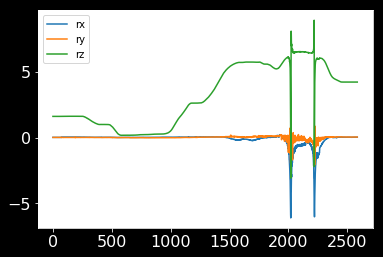

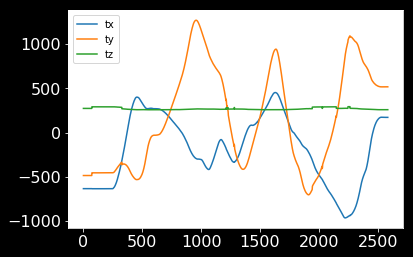

In [64]:
plt.plot(mocap_data[:,2], label="rx")
plt.plot(mocap_data[:,3], label="ry")
plt.plot(mocap_data[:,4], label="rz")
plt.legend()
plt.show()

plt.plot(mocap_data[:,5], label="tx")
plt.plot(mocap_data[:,6], label="ty")
plt.plot(mocap_data[:,7], label="tz")
plt.legend()
plt.show()

The above graphs illustrate that there was some strange behavior of the rotation measurements. It looks like wrap around

## Plot X/Y position from MoCap

This is what we will call our "ground truth" for the position of the robot over time.

In [65]:
mocap_states = np.ndarray((mocap_data.shape[0], 3))
mocap_states[0] = np.array([mocap_data[0,0], mocap_data[0,1], mocap_data[0,2]])
for mocap_idx in range(0, len(mocap_data)):
    data = mocap_data[mocap_idx]
    rx = data[2]
    ry = data[3]
    rz = data[4]
    tx = (data[5] + robot_center_offset[0]) / 1000
    ty = (data[6] + robot_center_offset[1]) / 1000
    tz = (data[7] + robot_center_offset[2]) / 1000
    mocap_states[mocap_idx][0] = tx
    mocap_states[mocap_idx][1] = ty
    mocap_states[mocap_idx][2] = rz
    

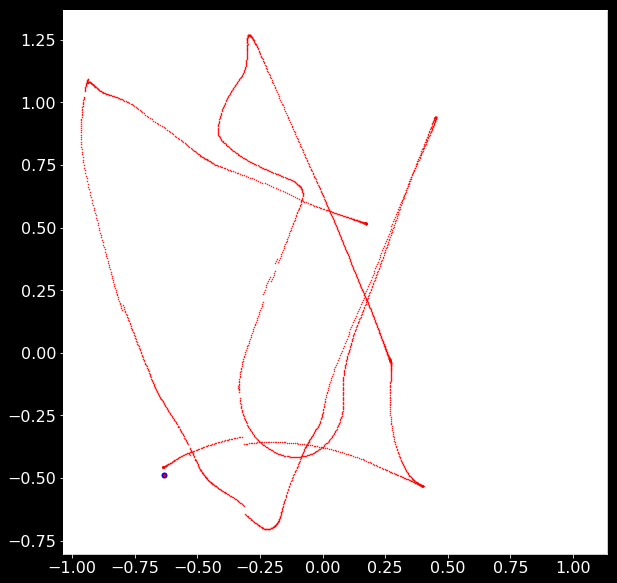

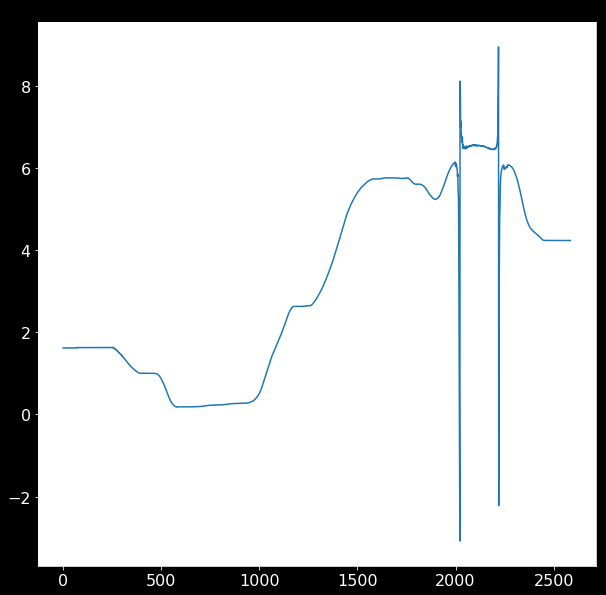

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(mocap_states[0,0], mocap_states[0,1], marker='.', s=100, color='b')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r')
plt.axis("square")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(mocap_states[:,2], label='yaw')
plt.title("mocap yaw")
plt.show()

Here's what the data looks like in that weird "jump". Turns out it's not actually a "jump" but smooth transition

In [67]:
print(mocap_states[2010:2030,2])

[ 5.7853  5.8465  5.6748  5.4769  5.3604  5.2978  4.6407  3.3344  2.6075
  1.0128 -1.0884 -1.7289 -3.0823  8.1099  8.0855  7.6677  6.9769  7.1383
  6.92    6.8603]


## Compute numeric velocit/acceleration from mocap

We take the numerical derivatives using a 3 point endpoint and midpoint approximations. We also compute the rotational velocity around the Z axis (yaw gyro rate) by 

In [68]:
N = mocap_states.shape[0]
mocap_vx = np.empty(N)
mocap_vy = np.empty(N)
mocap_ax = np.empty(N)
mocap_ay = np.empty(N)

h = 0.01 # mocap records at 100Hz

# endpoint approx
mocap_vx[0] = 1/(2*h)*(-3*mocap_states[0,0]+4*mocap_states[1,0]-mocap_states[2,0])
mocap_vy[0] = 1/(2*h)*(-3*mocap_states[0,1]+4*mocap_states[1,1]-mocap_states[2,1])

for i in range(1,N-1):
    # midpoint approx
    mocap_vx[i] = 1/(2*h)*(mocap_states[i+1,0]-mocap_states[i-1,0])
    mocap_vy[i] = 1/(2*h)*(mocap_states[i+1,1]-mocap_states[i-1,1])

# another endpoint approx
mocap_vx[-1] = 1/(2*h)*(-3*mocap_states[-1,0]+4*mocap_states[-2,0]-mocap_states[-3,0])
mocap_vy[-1] = 1/(2*h)*(-3*mocap_states[-1,1]+4*mocap_states[-2,1]-mocap_states[-3,1])

In [69]:
mocap_ax[0] = 1/(2*h)*(-3*mocap_vx[0]+4*mocap_vx[1]-mocap_vx[2])
mocap_ay[0] = 1/(2*h)*(-3*mocap_vy[0]+4*mocap_vy[1]-mocap_vy[2])

for i in range(1,N-1):
    # midpoint approx
    mocap_ax[i] = 1/(2*h)*(mocap_vx[i+1]-mocap_vx[i-1])
    mocap_ay[i] = 1/(2*h)*(mocap_vy[i+1]-mocap_vy[i-1])

# another endpoint approx
mocap_ax[-1] = 1/(2*h)*(-3*mocap_vx[-1]+4*mocap_vx[-2]-mocap_vx[-3])
mocap_ay[-1] = 1/(2*h)*(-3*mocap_vy[-1]+4*mocap_vy[-2]-mocap_vy[-3])

In [70]:
mocap_vx = np.clip(mocap_vx, -2, 2)
mocap_vy = np.clip(mocap_vy, -2, 2)

mocap_ax = np.clip(mocap_ax, -4, 4)
mocap_ay = np.clip(mocap_ay, -4, 4)

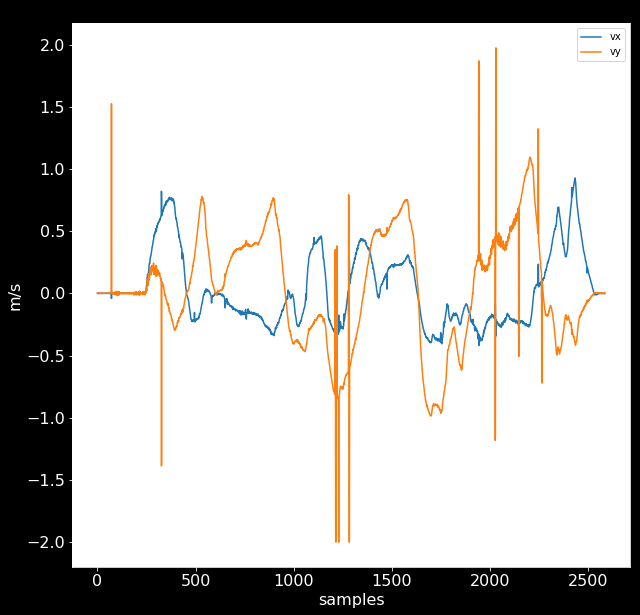

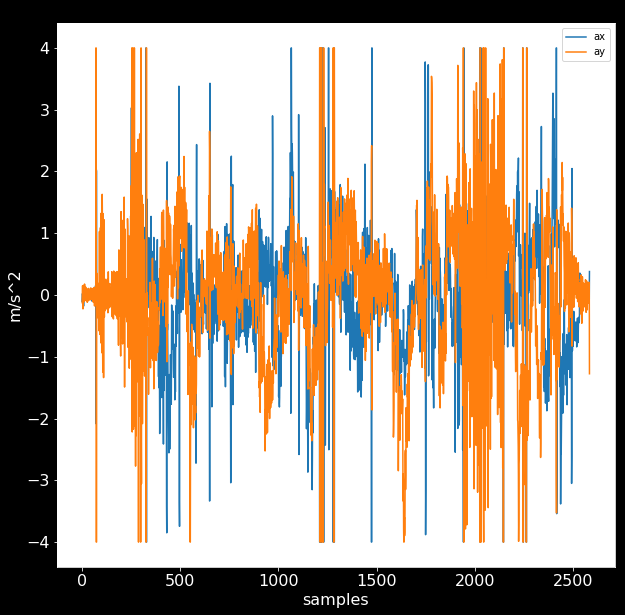

In [71]:
plt.figure(figsize=(10,10))
plt.plot(mocap_vx, label='vx')
plt.plot(mocap_vy, label='vy')
plt.legend()
plt.title("velocity derived numerically from mocap")
plt.ylabel("m/s")
plt.xlabel("samples")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(mocap_ax, label='ax')
plt.plot(mocap_ay, label='ay')
plt.legend()
plt.title("acc derived numerically from mocap")
plt.ylabel("m/s^2")
plt.xlabel("samples")
plt.show()

## Regard the first mocap pose as the "origin" for the dead reckoning methods

It's important to note that there are actually a bunch of points at the origin, then the origin jumps a few centimeters to another spot. I can't explain this but we'll just be aware of that as we compare against mocap.

In [72]:
global_origin_x = mocap_states[0,0]
global_origin_y = mocap_states[0,1]
global_origin_yaw = mocap_states[0,2]
global_origin_xy = np.array([[global_origin_x], [global_origin_y]])
print("Global Origin", [global_origin_x, global_origin_y, global_origin_yaw])

Global Origin [-0.634658, -0.486201, 1.61812]


## Uncalibrated data:

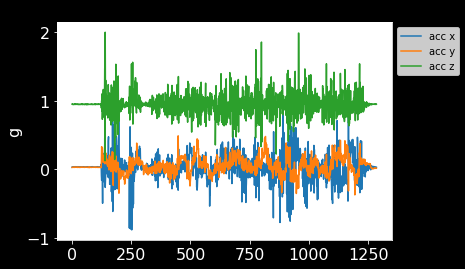

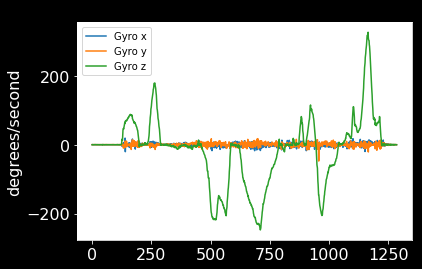

In [73]:
print_h2("Uncalibrated data:")
plt.plot(sensor_data[:,0], label="acc x")
plt.plot(sensor_data[:,1], label="acc y")
plt.plot(sensor_data[:,2], label="acc z")
plt.title("acc Data")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("g")
plt.show()

plt.plot(sensor_data[:,3], label="Gyro x")
plt.plot(sensor_data[:,4], label="Gyro y")
plt.plot(sensor_data[:,5], label="Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.ylabel("degrees/second")
plt.show()

# Calibration

We first apply the results of our IMU calibration experiment. Truthfully, they have little effect other than accounting for the magical $0.4$ constant we've been using. It's also worth noting that these numbers come from the the _other_ NavX so it's not really fair to use them but I want to illustrate the whole procedure.

In [74]:
def calibrate(input_data):
    # Ideal accelerometer calibration parameters
    acc_calibration_params = np.array([2.29299485e-03, 9.73357832e-04, 2.18891523e-03,
                                       9.97372417e-01, 9.98078141e-01, 9.95206414e-01,
                                       -8.12765191e-03, -1.24052008e-02, -1.41327621e-02])
    # Ideal gyro calibration parameters
    gyro_calibration_params = np.array([0.00844165, 0.00196508, -0.00410652,
                                       -0.01548789, -0.00191488, -0.00770839,
                                       0.40658698, 0.40275294, 0.40165824])
    
    Ta = np.array([[1, -acc_calibration_params[0], acc_calibration_params[1]],
                   [0, 1, -acc_calibration_params[2]],
                   [0, 0, 1]])
    Tg = np.array([[1, -gyro_calibration_params[0], gyro_calibration_params[1]],
                   [gyro_calibration_params[2], 1, -gyro_calibration_params[3]],
                   [-gyro_calibration_params[4], gyro_calibration_params[5], 1]])
    
    Ka = np.array([[acc_calibration_params[3], 0, 0],
                   [0, acc_calibration_params[4], 0],
                   [0, 0, acc_calibration_params[5]]])
    
    Kg = np.array([[gyro_calibration_params[6], 0, 0],
                   [0, gyro_calibration_params[7], 0],
                   [0, 0, gyro_calibration_params[8]]])

    ba = acc_calibration_params[6:9]
    bg = np.array([0.12964524, 0.15079131, 0.08211978])
    
    output_data = np.empty((input_data.shape[0], 6))
    output_data[:,0:3] = (Ta@Ka@(input_data[:,0:3] + ba).T).T
    output_data[:,3:6] = (Tg@Kg@(input_data[:,3:6] + bg).T).T
    
    return output_data
    
calibrated_imu_data = calibrate(sensor_data)

## Calibrated data vs Raw Data

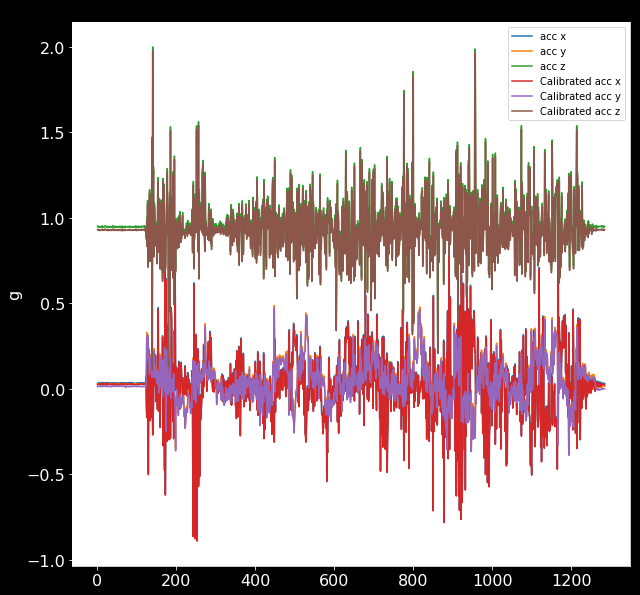

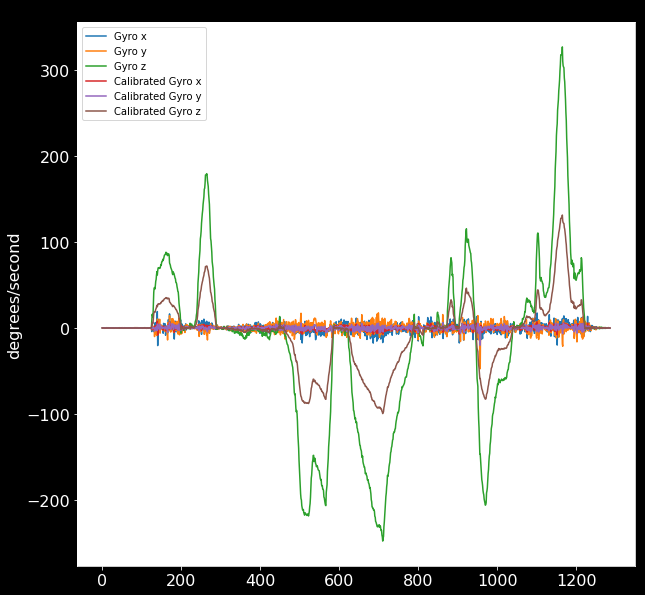

In [75]:
print_h2("Calibrated data vs Raw Data")
plt.figure(figsize=(10,10))
plt.plot(sensor_data[:,0], label="acc x")
plt.plot(sensor_data[:,1], label="acc y")
plt.plot(sensor_data[:,2], label="acc z")
plt.plot(calibrated_imu_data[:,0], label="Calibrated acc x")
plt.plot(calibrated_imu_data[:,1], label="Calibrated acc y")
plt.plot(calibrated_imu_data[:,2], label="Calibrated acc z")
plt.title("acc Data")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("g")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(sensor_data[:,3], label="Gyro x")
plt.plot(sensor_data[:,4], label="Gyro y")
plt.plot(sensor_data[:,5], label="Gyro z")
plt.plot(calibrated_imu_data[:,3], label="Calibrated Gyro x")
plt.plot(calibrated_imu_data[:,4], label="Calibrated Gyro y")
plt.plot(calibrated_imu_data[:,5], label="Calibrated Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.ylabel("degrees/second")
plt.show()

# Base frame calibration

## Calibrated and Rotated versus Original Data

some differences are visible, especially in the gyroscope


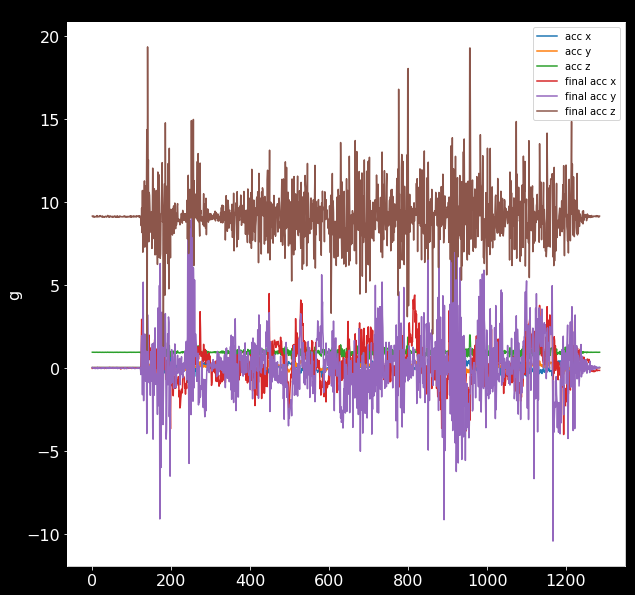

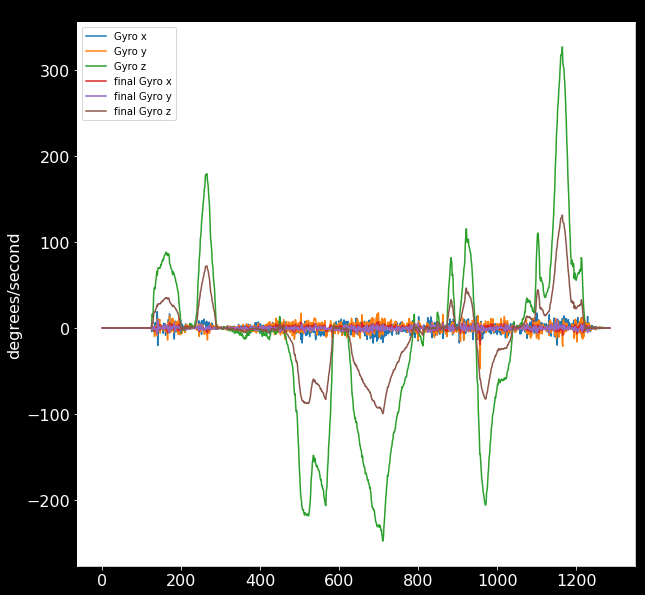

In [76]:
def base_rotation(mean_acc_while_stationary):
    """ https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d """
    a = mean_acc_while_stationary
    b = np.array([0, 0, 1])
    v = np.cross(a, b)
    c = np.dot(a, b)
    v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.eye(3) + v_x + (v_x@v_x)*(1/(1+c))
    return R
   
t_init = 100 # samples of the robot while stationary
stationary_accelerometer_data = calibrated_imu_data[:t_init,0:3]
stationary_mean_acc_raw = np.mean(stationary_accelerometer_data, axis=0)
stationary_mean_acc = stationary_mean_acc_raw / np.linalg.norm(stationary_mean_acc_raw)

# account for the yaw angle of the robot versus IMU (after it's rotated flat)
robot_to_imu_yaw = -np.pi/2
base_yaw_rot = np.array([[np.cos(robot_to_imu_yaw), -np.sin(robot_to_imu_yaw), 0],
                        [np.sin(robot_to_imu_yaw), np.cos(robot_to_imu_yaw), 0],
                        [0, 0, 1]])

R = base_yaw_rot @ base_rotation(stationary_mean_acc)

final_imu_data = np.empty(calibrated_imu_data.shape)
final_imu_data[:,0:3] = (R @ calibrated_imu_data[:,0:3].T).T
final_imu_data[:,3:6] = (R @ calibrated_imu_data[:,3:6].T).T

# convert from g's to m/s^2
final_imu_data[:,0:3] *= 9.8

print_h2("Calibrated and Rotated versus Original Data")
print("some differences are visible, especially in the gyroscope")

plt.figure(figsize=(10,10))
plt.plot(sensor_data[:,0], label="acc x")
plt.plot(sensor_data[:,1], label="acc y")
plt.plot(sensor_data[:,2], label="acc z")
plt.plot(final_imu_data[:,0], label="final acc x")
plt.plot(final_imu_data[:,1], label="final acc y")
plt.plot(final_imu_data[:,2], label="final acc z")
plt.title("acc Data")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("g")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(sensor_data[:,3], label="Gyro x")
plt.plot(sensor_data[:,4], label="Gyro y")
plt.plot(sensor_data[:,5], label="Gyro z")
plt.plot(final_imu_data[:,3], label="final Gyro x")
plt.plot(final_imu_data[:,4], label="final Gyro y")
plt.plot(final_imu_data[:,5], label="final Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.ylabel("degrees/second")
plt.show()

## Calibration Complete!

The data is now read to be processed by a Kalman Filter or double integrated or whatever else you want

In [77]:
def PositionFromIMU(imu_data, dt_s, x0, y0, yaw0):
    """
    This is the double integration method
    
    Args:
        imu_data (ndarray(?x6)) the first three columns are assumed to be accelerometer x,y,z. Columns 3-6 are gyro x,y,z
        dt_s (float) the time between samples in imu_data in seconds
        x0 (float) initial x position
        y0 (float) initial y position
        yaw0 (float) initial yaw angle
    """
    x = x0
    y = y0
    vx = 0
    vy = 0
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    yaw_rad = yaw0
    for d in imu_data:
        a = d[:3] + [0, 0, 0]
        gyro_z = d[5]
        yaw_rad += dt_s * -np.deg2rad(gyro_z)
        yaw_rot = np.array([[np.cos(yaw_rad), -np.sin(yaw_rad), 0], [np.sin(yaw_rad), np.cos(yaw_rad), 0], [0, 0, 1]])
        a = yaw_rot @ a
        ax = a[0]
        ay = a[1]
        
        x += vx * dt_s + 0.5 * ax * (dt_s ** 2)
        y += vy * dt_s + 0.5 * ay * (dt_s ** 2)
        vx += ax * dt_s
        vy += ay * dt_s
                
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

## Compare numerical derived acceleration to measure acceleration

we can do this now that we've done calibration

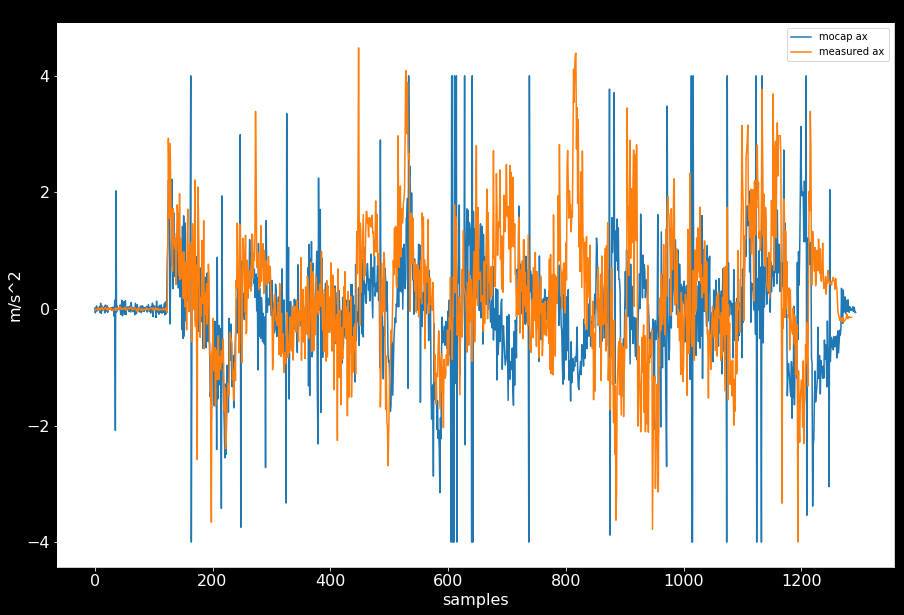

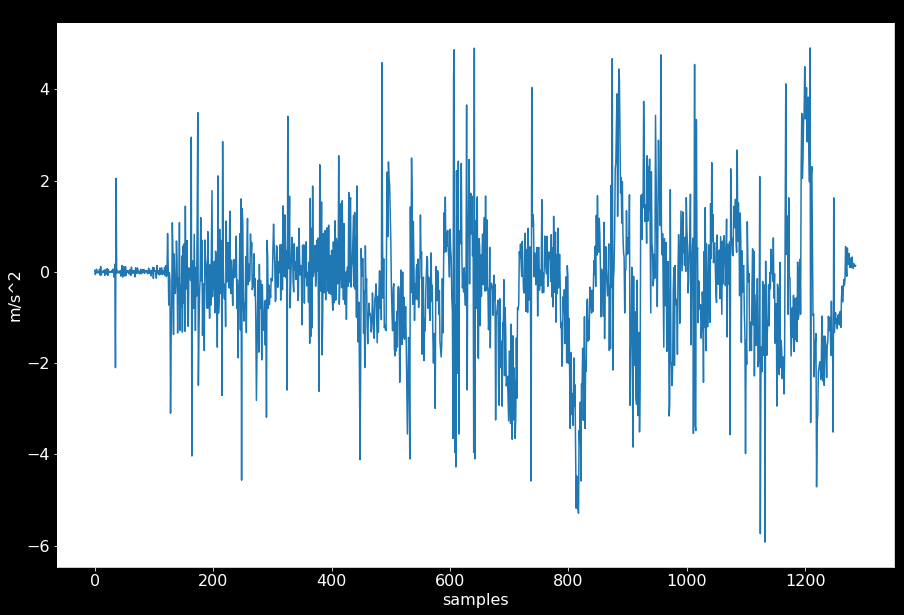

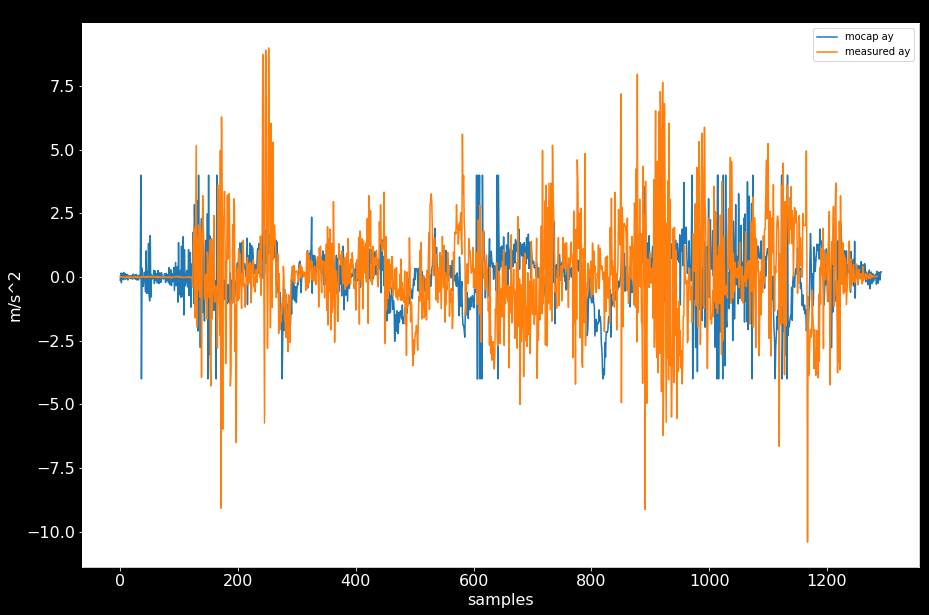

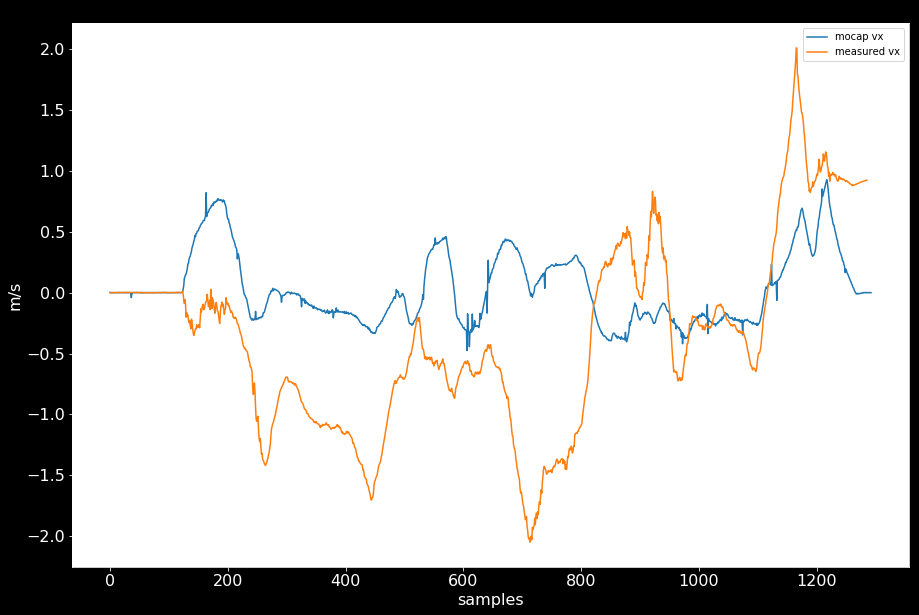

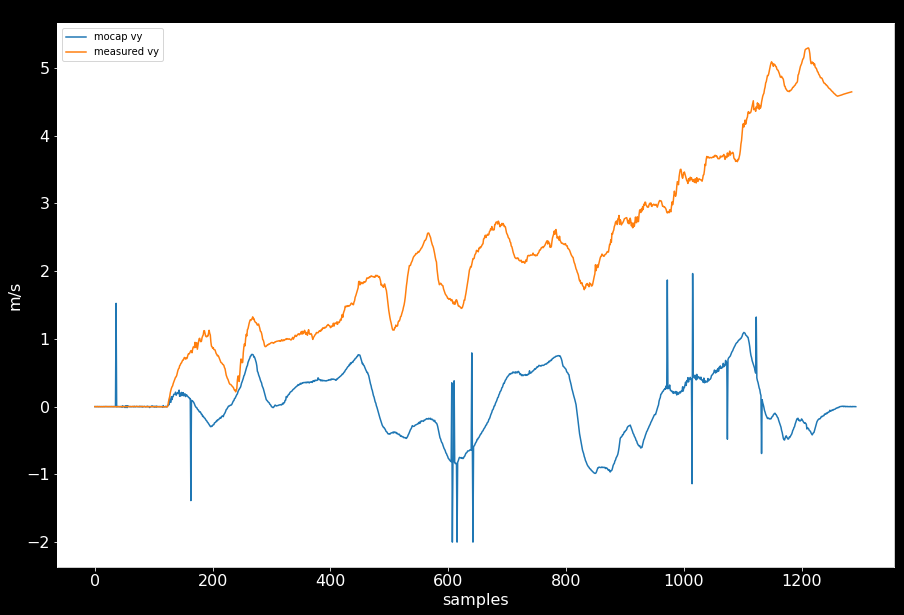

In [78]:
plt.figure(figsize=(15,10))
plt.plot(mocap_ax[::2], label='mocap ax')
plt.plot(final_imu_data[:,0], label='measured ax')
plt.legend()
plt.title("Acceleration in X")
plt.ylabel("m/s^2")
plt.xlabel("samples")

plt.figure(figsize=(15,10))
plt.plot(mocap_ax[:2572:2] - final_imu_data[:1286,0])
plt.title("Difference in Acceleration in X")
plt.ylabel("m/s^2")
plt.xlabel("samples")

plt.figure(figsize=(15,10))
plt.plot(mocap_ay[::2], label='mocap ay')
plt.plot(final_imu_data[:,1], label='measured ay')
plt.legend()
plt.title("Acceleration in Y")
plt.ylabel("m/s^2")
plt.xlabel("samples")

# Velocity
temp_intergration = PositionFromIMU(final_imu_data, 0.02, global_origin_x, global_origin_y, global_origin_yaw)

plt.figure(figsize=(15,10))
plt.plot(mocap_vx[::2], label='mocap vx')
plt.plot(temp_intergration[2], label='measured vx')
plt.legend()
plt.title("Velocity in X")
plt.ylabel("m/s")
plt.xlabel("samples")

plt.figure(figsize=(15,10))
plt.plot(mocap_vy[::2], label='mocap vy')
plt.plot(temp_intergration[3], label='measured vy')
plt.legend()
plt.title("Velocity in Y")
plt.ylabel("m/s")
plt.xlabel("samples")
plt.show()

This is surprisingly similar. Especially in the beginning they seem to match very well.

What if we double integrate the twice differentiated mocap data?

In [79]:
# fake_mocap_data = np.zeros((len(mocap_ax), 6))
# fake_mocap_data[:,0] = mocap_ax
# fake_mocap_data[:,1] = mocap_ay
# fake_mocap_data[:,5] = mocap_gyro_z
# PositionFromIMU(fake_mocap_data, dt_s, global_origin_x, global_origin_y, global_origin_yaw)

## Integrating Navx Gyro to get Angle

In [90]:
yaws = []
yaw = np.rad2deg(global_origin_yaw)
for data in final_imu_data:
    gyro_z = -data[5]  # the negative sign is to tf into mocap frame
    yaw += 0.02 * gyro_z
    yaws.append(yaw)
    
naive_yaws = []
og_yaw = np.rad2deg(global_origin_yaw)
for data in sensor_data:
    gyro_z = -data[5] * 2000/4985
    og_yaw += 0.02 * gyro_z
    naive_yaws.append(og_yaw)

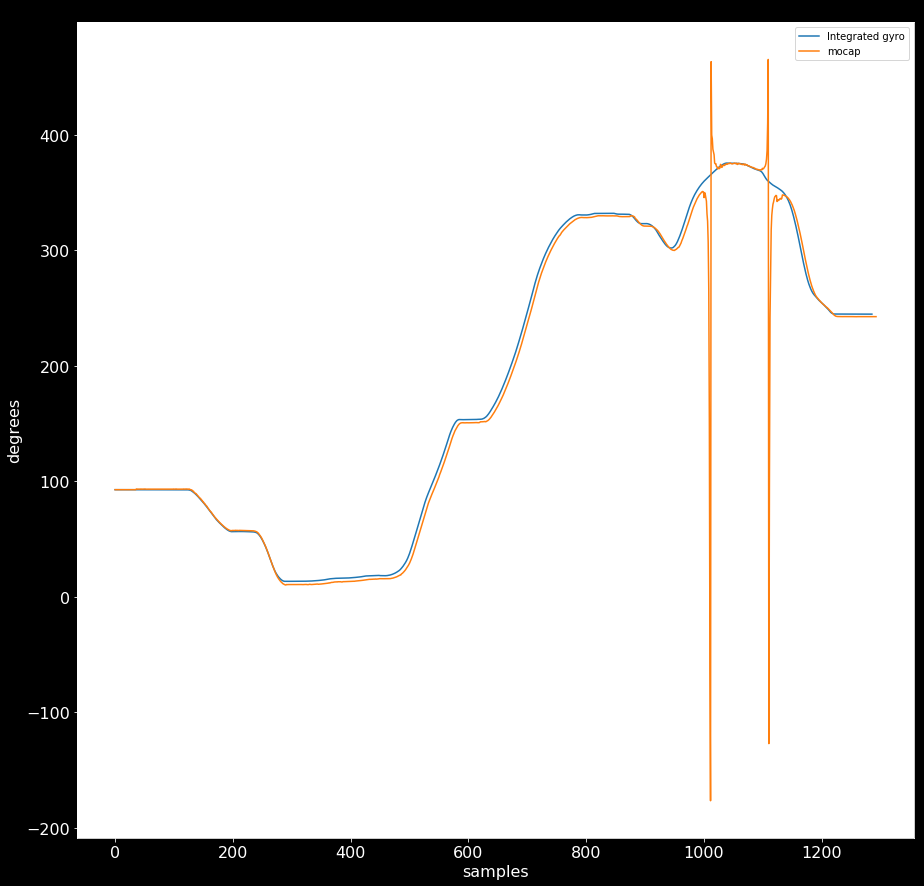

Maximum error over the mocap (ignoring outliner)
2.4965987383350807


In [96]:
plt.figure(figsize=(15,15))
plt.plot(yaws, label="Integrated gyro")
# sample every other point (50hz versus 100hz collection) and convert to degrees
mocap_yaw_deg = np.rad2deg(mocap_states[0:-1:2,2])
plt.plot(mocap_yaw_deg, label='mocap')
plt.ylabel("degrees")
plt.xlabel("samples")
plt.title("Yaw of robot")
plt.legend()
plt.show()

print("Maximum error over the mocap (ignoring outliner)")
print(np.max(mocap_yaw_deg[:1000] - yaws[:1000]))

This suggests that the IMU calibration is not correct.
A naive 0.4 and just as good as the calibrated and rotated data.
It seems to make the intgrated yaw **worse**

# Analysis of accurate of Integrating Yaw from NavX Gyro

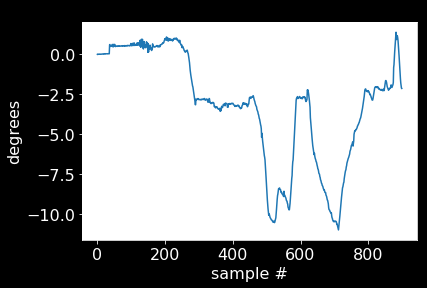

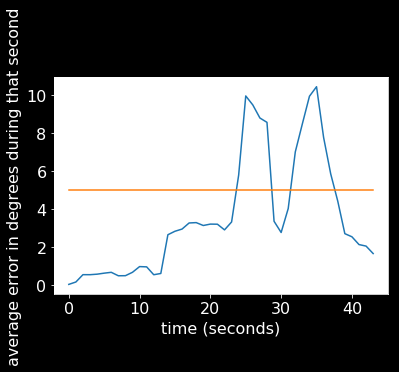

from this it is not clear whether gyro drift plays a role in the error. However, error is within 5 degrees for the first 20 seconds.


In [82]:
error = (np.rad2deg(mocap_states[0:-1:2,2])[:len(yaws)] - yaws[:len(yaws)])

# ignore outlies
error = error[:900]

average_error_by_second = []
for i in range(1, error.shape[0] // 20):
    average_error_by_second.append(np.mean(abs(error[(i-1)*20:i*20])))

plt.plot(error)
plt.xlabel("sample #")
plt.ylabel("degrees")
plt.title("Error between Gyro integration and Mocap data")
plt.show()

plt.figure()
plt.plot(average_error_by_second)
plt.plot([5]*len(average_error_by_second))
plt.title("averge error by second")
plt.xlabel("time (seconds)")
plt.ylabel("average error in degrees during that second")
plt.show()

print("from this it is not clear whether gyro drift plays a role in the error. However, error is within 5 degrees for the first 20 seconds.")

# X/Y from NavX

In [83]:
# adjust the NavX data to start with the correct global X, Y, and Yaw
navx_x = sensor_data[:,6] - sensor_data[0,6]
navx_y = sensor_data[:,7] - sensor_data[0,7]
navx_xy = np.vstack((navx_x, navx_y))

# subtract initial X/Y (idk why this is not just 0???)
global_yaw_rot = np.array([[np.cos(global_origin_yaw), -np.sin(global_origin_yaw)], [np.sin(global_origin_yaw), np.cos(global_origin_yaw)]])
navx_xy = (global_yaw_rot@navx_xy) + global_origin_xy

# Encoder

In [84]:
# encoder kinematics
encoder_x = global_origin_x
encoder_y = global_origin_y
encoder_yaw = mocap_states[0][2]
encoder_xs = []
encoder_ys = []
alpha = 1.0
wheel_radius_m = 0.074
track_width_m = 0.9
dt_s = 0.05

distance_per_pulse = 0.000357 # measured on mocap robot

for data in sensor_data:
    wl = float(data[9]) * distance_per_pulse
    wr = float(data[10]) * distance_per_pulse
    
    B = alpha * track_width_m
    T = wheel_radius_m / B * np.array([[B / 2.0, B / 2.0], [-1, 1]])
    dydt, dpdt = T @ np.array([wl, wr])
    encoder_x = encoder_x + np.cos(encoder_yaw) * dydt * dt_s
    encoder_y = encoder_y + np.sin(encoder_yaw) * dydt * dt_s
    encoder_yaw += dpdt * dt_s
    
    encoder_xs.append(encoder_x)
    encoder_ys.append(encoder_y)

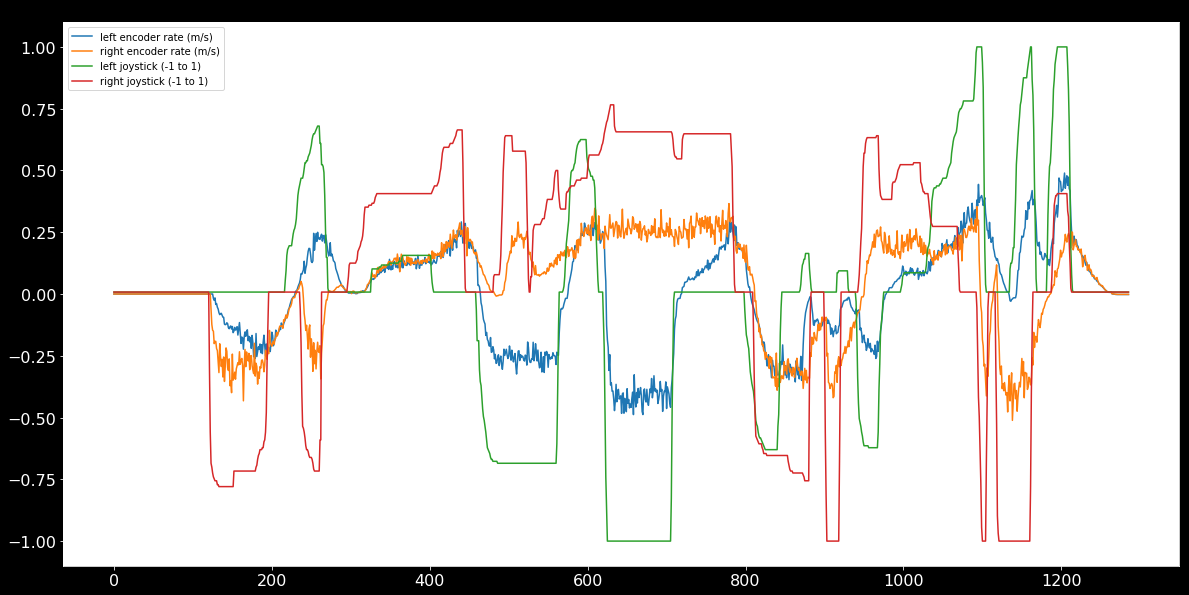

In [85]:
plt.figure(figsize=(20,10))
plt.plot(sensor_data[:,9]*distance_per_pulse,label='left encoder rate (m/s)')
plt.plot(sensor_data[:,10]*distance_per_pulse, label='right encoder rate (m/s)')
plt.plot(-sensor_data[:,11],label='left joystick (-1 to 1)')
plt.plot(sensor_data[:,12], label='right joystick (-1 to 1)')
plt.title("encoder on MoCap robot")
plt.legend()
plt.show()

## Double Integrate Mocap Robot Sensor Data

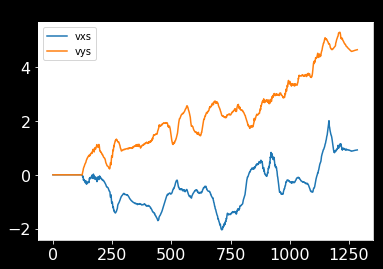

In [86]:
pva_from_imu = PositionFromIMU(final_imu_data, 0.02, global_origin_x, global_origin_y, global_origin_yaw)

plt.plot(pva_from_imu[2], label="vxs")
plt.plot(pva_from_imu[3], label="vys")
plt.title("velocities from IMU")
plt.legend()
plt.show()

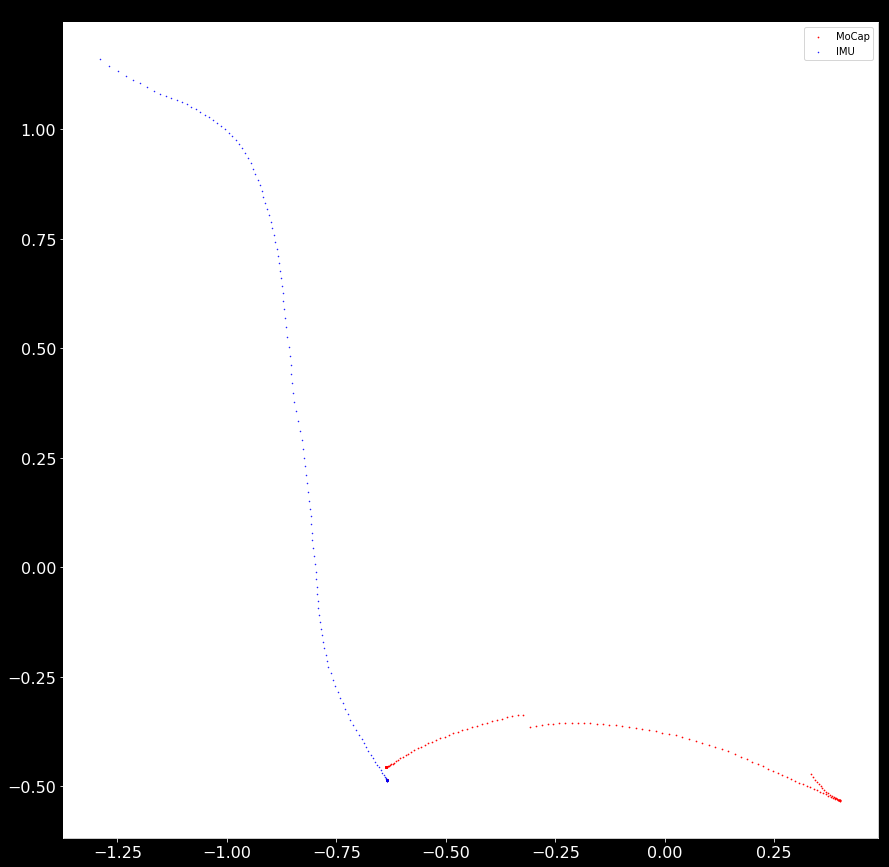

In [87]:
plt.figure(figsize=(15,15))
plt.title("Sensor Data versus MoCap")
TT = 250

# :2 accounts for the fact the the mocap samples twice as fast as our encoder/IMU data
plt.scatter(mocap_states[:TT*2:2,0], mocap_states[:TT*2:2,1], marker='.', s=2, color='r', label='MoCap')

# plt.scatter(encoder_xs[:TT], encoder_ys[:TT], marker='.', s=2, color='k', label='encoders')
# plt.scatter(navx_xy[0,:TT], navx_xy[1,:TT], marker='.', s=2, color='y', label="navx API")
plt.scatter(pva_from_imu[0][:TT], pva_from_imu[1][:TT], marker='.', s=1, color='b', label='IMU')
plt.axis("square")

plt.legend()
plt.show()

## Comparing TimeStamp Accuracy between NavX and RoboRIO (FPGA)

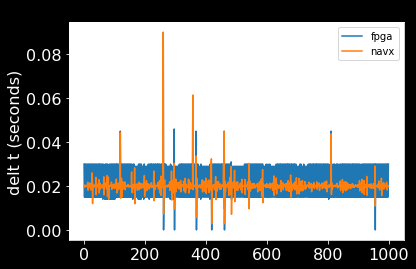

In [88]:
dts_fpgas = []
dts_navxs = []
for i in range(1000):
    dt_s_fpga = (sensor_data[i+1][-1] - sensor_data[i][-1]) / 1000
    dt_s_navx = (sensor_data[i+1][-2] - sensor_data[i][-2])
    dts_fpgas.append(dt_s_fpga)
    dts_navxs.append(dt_s_navx)
    
plt.plot(dts_fpgas, label='fpga')
plt.plot(dts_navxs, label='navx')
plt.ylabel("delt t (seconds)")
plt.legend()
plt.title("Sensor reading timestamps")
plt.show()